dataset Traffic CCTV Footages for Lane Monitoring

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !kaggle datasets download -d pranayobla/lane-monitoring

Dataset URL: https://www.kaggle.com/datasets/pranayobla/lane-monitoring
License(s): apache-2.0
 99% 78.0M/78.8M [00:05<00:00, 18.1MB/s]
100% 78.8M/78.8M [00:05<00:00, 14.3MB/s]


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 43.4 MB/s eta 0:00:00


In [ ]:
import os
import math
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

##Dataset Traffic CCTV Footages for Lane Monitoring

In [ ]:
# import zipfile

# # Define the path to the zip file and extraction folder
# zip_file_path = '/content/lane-monitoring.zip'
# extract_to_path = '/content/drive/MyDrive/T5/WEEK_6/min_project3/dataset/lane_monitoring/'

# # Extract the contents
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)


### Load model YOLO

In [ ]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 252MB/s]


###sample image display


image 1/1 /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/train/images/4K-Road-traffic-video-for-object-detection-and-tracking_001_jpg.rf.721961be96c4f175f42ba62f96a6b2eb.jpg: 640x640 3 cars, 1 truck, 16.5ms
Speed: 10.3ms preprocess, 16.5ms inference, 711.4ms postprocess per image at shape (1, 3, 640, 640)


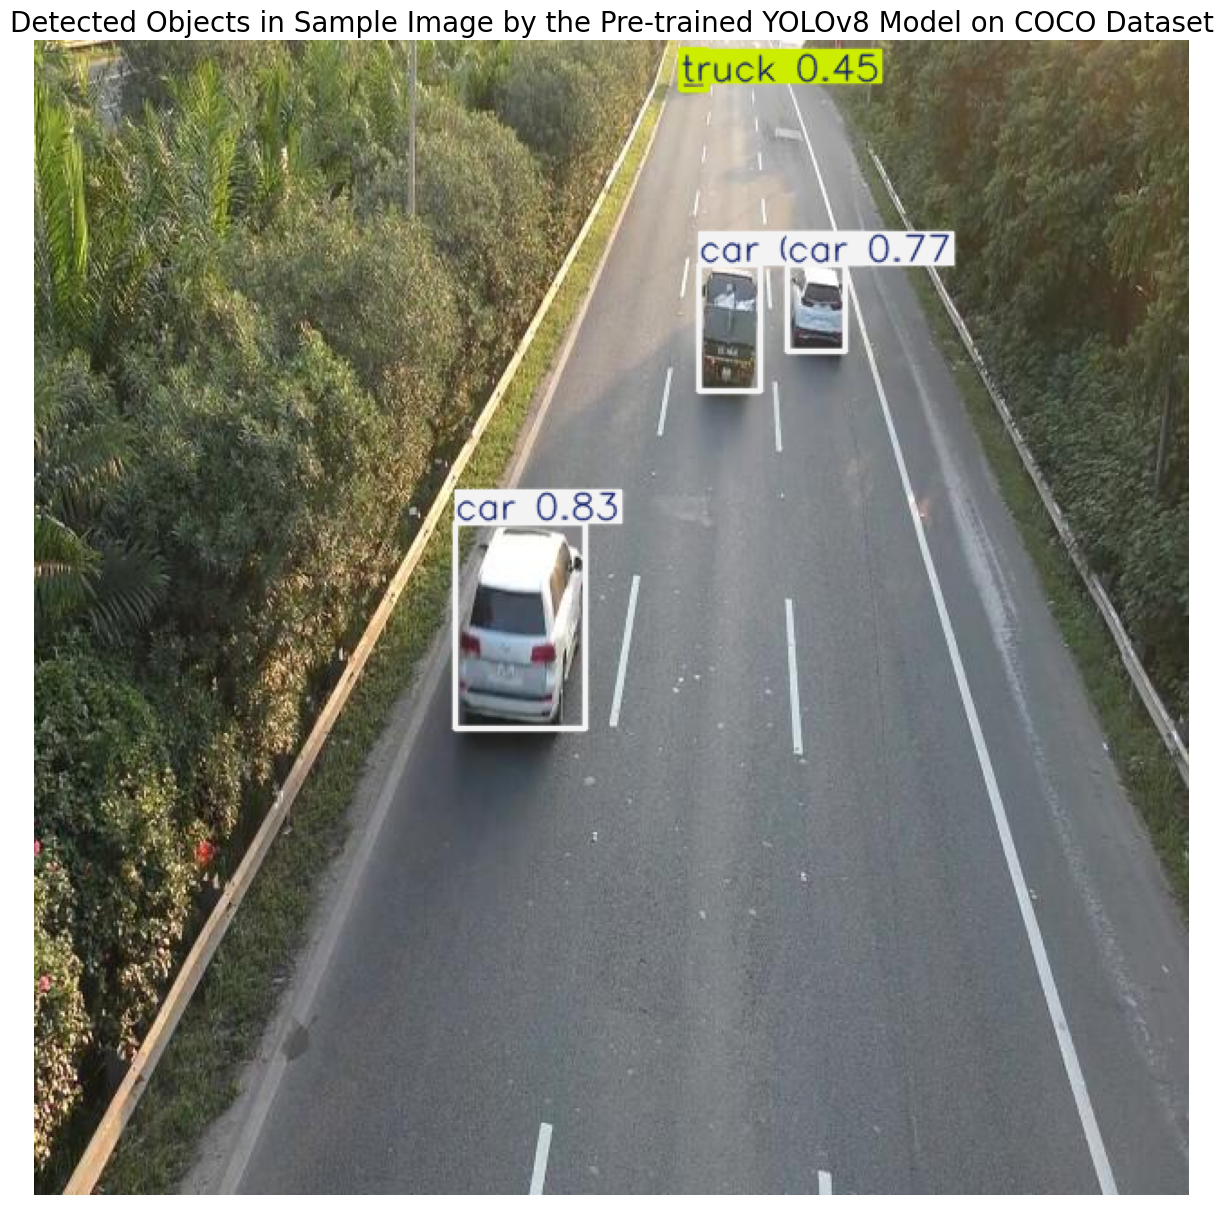

In [ ]:
# Path to the image file
image_path = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/train/images/4K-Road-traffic-video-for-object-detection-and-tracking_001_jpg.rf.721961be96c4f175f42ba62f96a6b2eb.jpg'

# Perform inference on the provided image(s)
results = model.predict(source=image_path,
                        imgsz=640,  # Resize image to 640x640 (the size pf images the model was trained on)
                        conf=0.3)   # Confidence threshold: 50% (only detections above 50% confidence will be considered)

# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Pre-trained YOLOv8 Model on COCO Dataset', fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
# Define the dataset_path
dataset_path = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- IN LANE
- OUT OF LANE
nc: 2
test: /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/test
train: /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/train/images
val: /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/val/images



Total images: 974
Images with annotations: 914
Images without annotations: 60


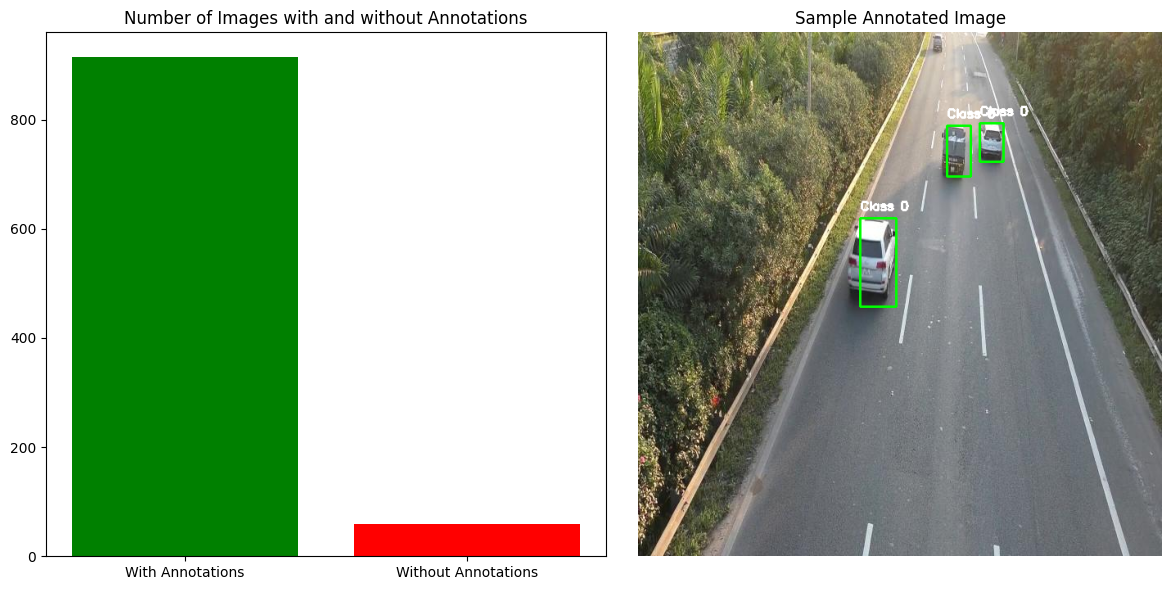

In [ ]:
image_dir = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/train/images'
label_dir = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/train/labels'

# List all images and labels
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [f.replace('.jpg', '.txt') for f in image_files]

# Separate images with and without annotations
images_with_annotations = []
images_without_annotations = []

for image_file, label_file in zip(image_files, label_files):
    if os.path.exists(os.path.join(label_dir, label_file)):
        images_with_annotations.append(image_file)
    else:
        images_without_annotations.append(image_file)

# Print counts
print(f"Total images: {len(image_files)}")
print(f"Images with annotations: {len(images_with_annotations)}")
print(f"Images without annotations: {len(images_without_annotations)}")

# Plot EDA
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for counts
ax[0].bar(['With Annotations', 'Without Annotations'], [len(images_with_annotations), len(images_without_annotations)], color=['green', 'red'])
ax[0].set_title('Number of Images with and without Annotations')

# Show a few sample images with annotations
sample_images = images_with_annotations[:3]  # Show first 3 images with annotations

for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))

    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape  # Get image dimensions

    # Plot annotations
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            if len(values) >= 5:  # Ensure there are at least 5 values
                class_id, x_center, y_center, width, height = map(float, values[:5])  # Only take the first 5 values

                # Convert normalized coordinates to pixel values
                x_center, y_center = x_center * w, y_center * h
                width, height = width * w, height * h

                # Calculate the top-left and bottom-right coordinates
                x1, y1 = int(x_center - width / 2), int(y_center - height / 2)
                x2, y2 = int(x_center + width / 2), int(y_center + height / 2)

                # Draw the bounding box
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, f'Class {int(class_id)}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Show image with annotations
    ax[1].imshow(img)
    ax[1].set_title('Sample Annotated Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'val', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 974
Number of validation images: 229
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


#Sample Images from Training Dataset

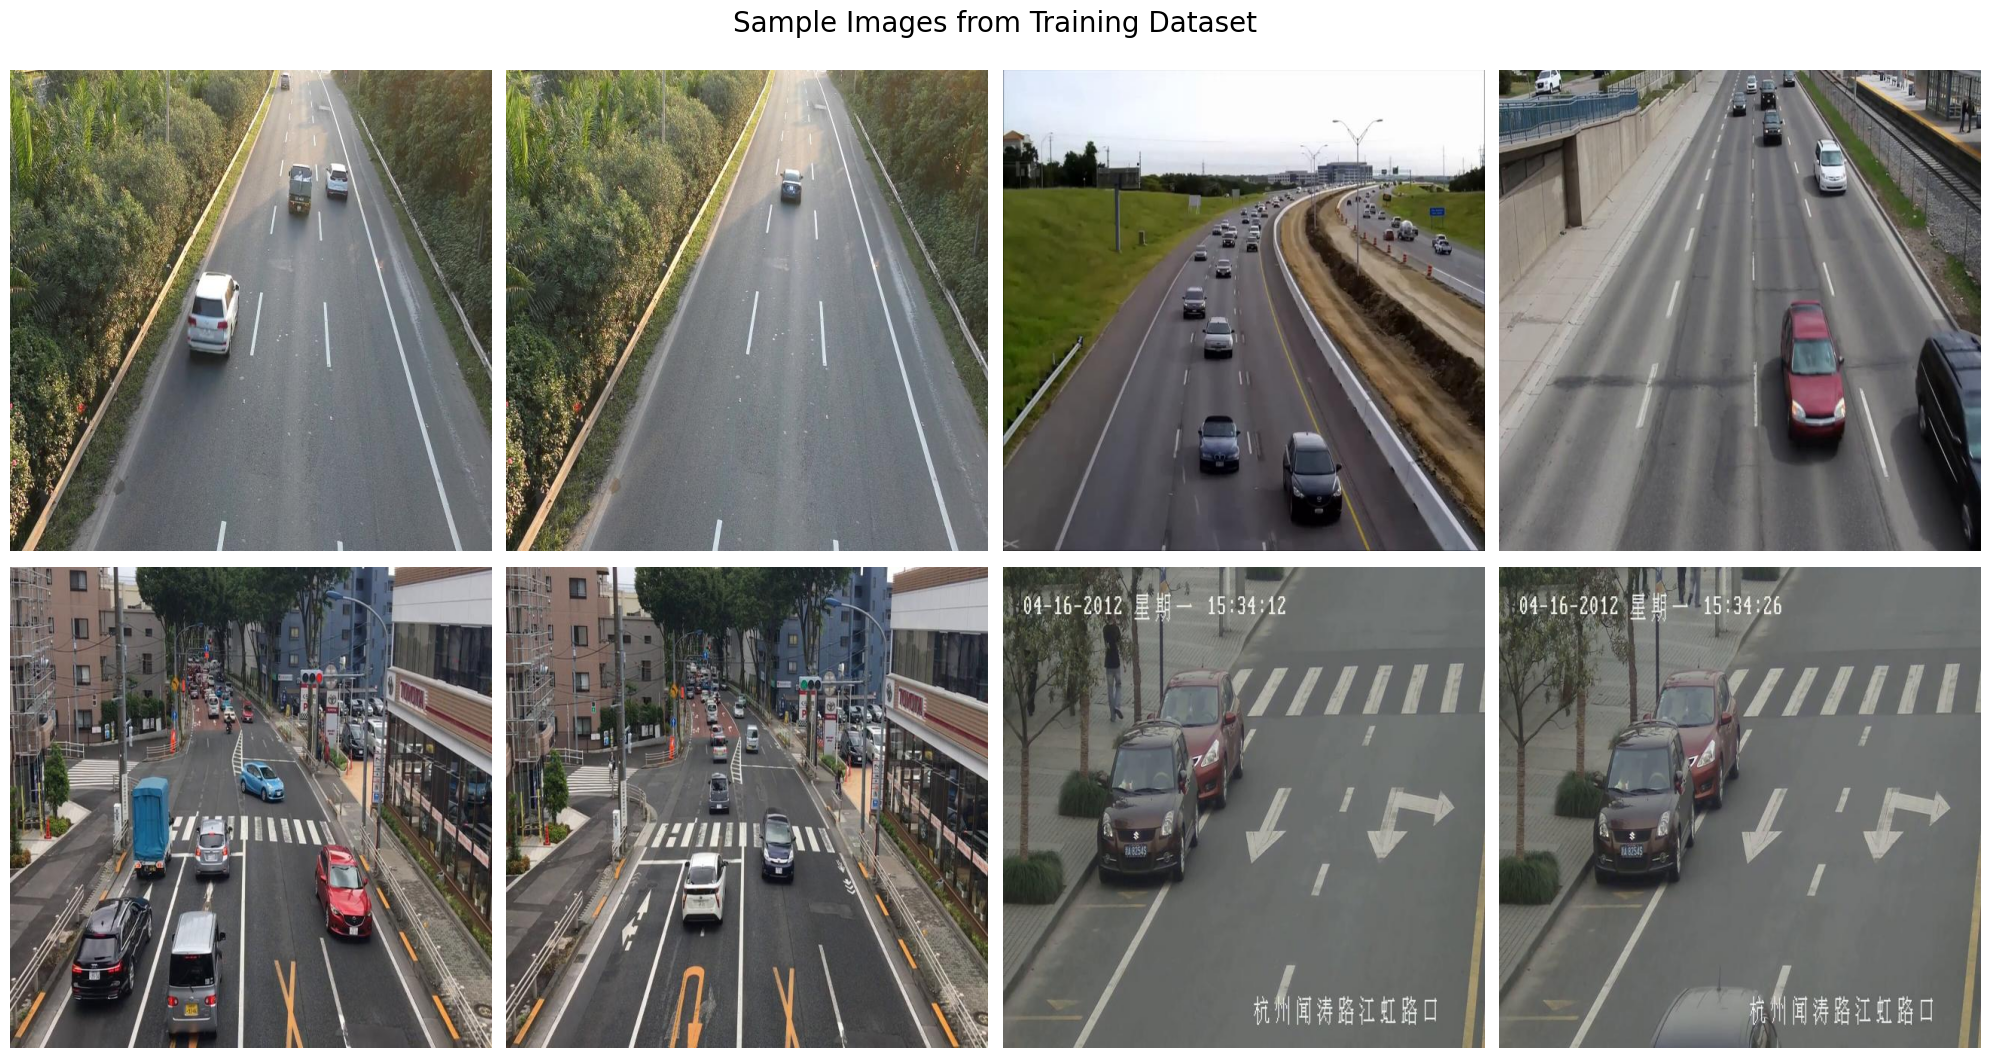

In [ ]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
label_path = os.path.join(label_dir, label_files[0])  # Pick the first annotation file

with open(label_path, 'r') as file:
    for line in file:
        print(line.strip())

0 0.440625 0.50546875 0.06796875 0.16875
0 0.60078125 0.25703125 0.04453125 0.096875
0 0.678125 0.234375 0.0453125 0.07265625


#Data Augmentations

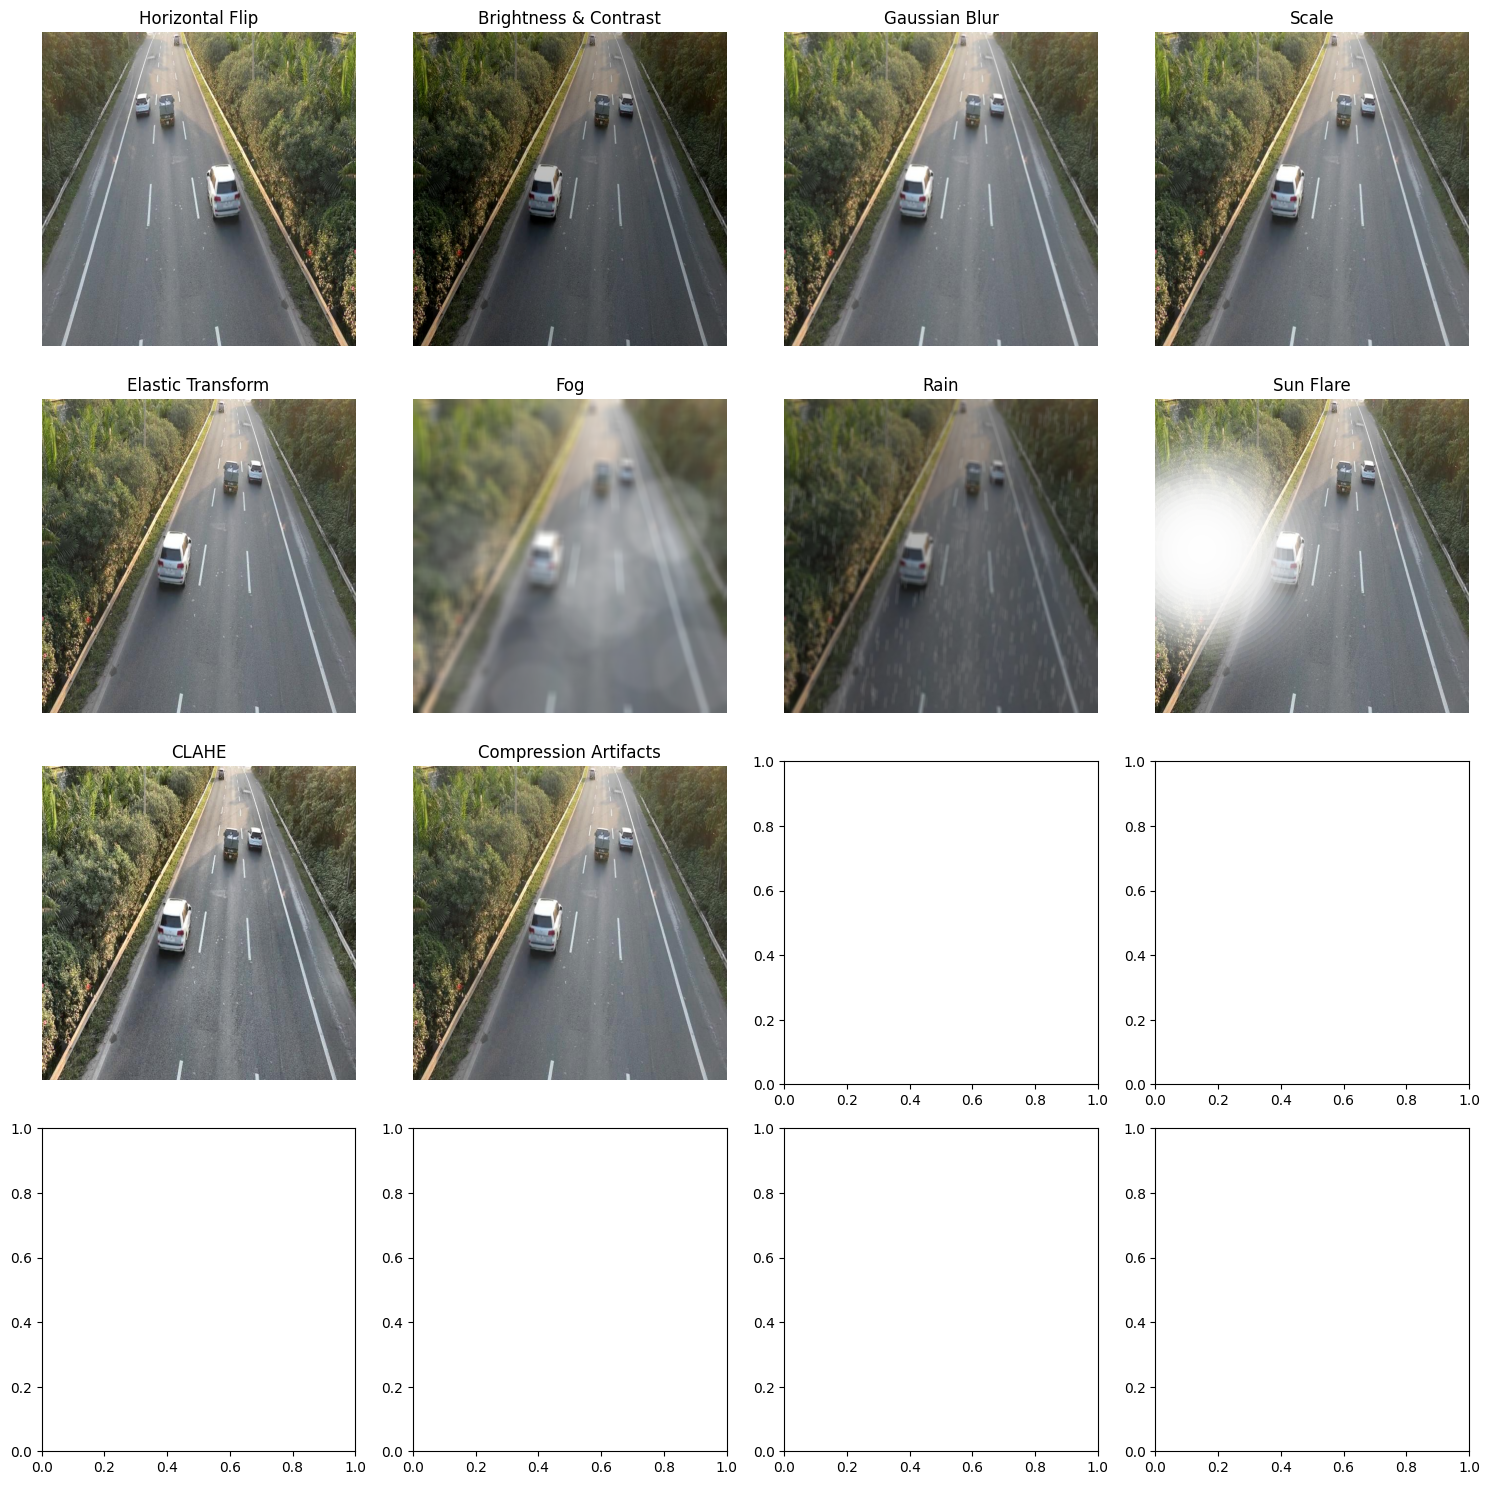

In [ ]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt

# Load an example image
image_path = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/train/images/4K-Road-traffic-video-for-object-detection-and-tracking_001_jpg.rf.721961be96c4f175f42ba62f96a6b2eb.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define augmentations
augmentations = {
    "Horizontal Flip": A.HorizontalFlip(p=1.0),
    "Brightness & Contrast": A.RandomBrightnessContrast(p=1.0),
    "Gaussian Blur": A.GaussianBlur(blur_limit=(3, 7), p=1.0),
    "Scale": A.RandomScale(scale_limit=0.2, p=1.0),
    "Elastic Transform": A.ElasticTransform(alpha=1.0, sigma=50, p=1.0),
    "Fog": A.RandomFog(fog_coef_limit=0.1, p=1.0),
    "Rain": A.RandomRain(p=1.0),
    "Sun Flare": A.RandomSunFlare(p=1.0),
    "CLAHE": A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    "Compression Artifacts": A.ImageCompression(quality_lower=50, quality_upper=100, p=1.0)
}

# Apply and display augmentations
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
axs = axs.flatten()
for i, (name, aug) in enumerate(augmentations.items()):
    augmented = aug(image=image_rgb)
    axs[i].imshow(augmented['image'])
    axs[i].set_title(name)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm


# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=1.0),
    A.GaussianBlur(blur_limit=(3, 7), p=1.0),
    A.RandomScale(scale_limit=0.2, p=1.0),
    A.ElasticTransform(alpha=1.0, sigma=50, p=1.0),
    A.RandomFog(fog_coef_limit=0.1, p=1.0),
    A.RandomRain(p=1.0),
    A.RandomSunFlare(p=1.0),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.ImageCompression(quality_lower=50, quality_upper=100, p=1.0)
])

# Set paths
train_image_dir = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/train'
augmented_image_dir = '/content/drive/MyDrive/T5/WEEK_6/dataset/lane_monitoring/data/train/images_augmented'

# Create a directory to save augmented images
os.makedirs(augmented_image_dir, exist_ok=True)

# Perform augmentation
for image_name in tqdm(os.listdir(train_image_dir)):
    image_path = os.path.join(train_image_dir, image_name)
    image = cv2.imread(image_path)

    if image is None:
        # Skip if the image cannot be read
        print(f"Warning: Unable to read image {image_name}. Skipping.")
        continue

    # Convert image from BGR to RGB for augmentation
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    try:
        # Apply augmentation
        augmented = augmentations(image=image_rgb)
        augmented_image = augmented['image']

        # Convert augmented image from RGB to BGR
        augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

        # Save augmented image
        augmented_image_name = f"aug_{image_name}"
        cv2.imwrite(os.path.join(augmented_image_dir, augmented_image_name), augmented_image_bgr)
        print(f"Augmented image saved: {augmented_image_name}")

    except Exception as e:
        print(f"Error processing image {image_name}: {e}")

print(f"Data augmentation completed. Augmented images saved in: {augmented_image_dir}")


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

Data augmentation completed. Augmented images saved in: /content/drive/MyDrive/T5/WEEK_6/min_project3/dataset/lane_monitoring/data/train/images_augmented


# Training and Evaluation  model

In [ ]:
# Train the YOLOv8 model
model.train(
    data='/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/data.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    name='lane_detection_yolov8s',
    workers=4
)

Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=lane_detection_yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

100%|██████████| 755k/755k [00:00<00:00, 97.8MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 150MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/train/labels... 914 images, 109 backgrounds, 0 corrupt: 100%|██████████| 974/974 [01:30<00:00, 10.75it/s]


train: New cache created: /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 184, len(boxes) = 4456. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/val/labels... 229 images, 12 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:25<00:00,  9.00it/s]


val: New cache created: /content/drive/MyDrive/T5/capston project/min_project3/dataset/lane_monitoring/data/val/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 42, len(boxes) = 1073. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/lane_detection_yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/lane_detection_yolov8n
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  I

       1/30       4.1G      1.996      2.191      1.514        148        640: 100%|██████████| 61/61 [00:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]

                   all        229       1073      0.459      0.478      0.435      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       3.9G      1.578      1.149      1.258        111        640: 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        229       1073      0.621      0.495       0.56      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.14G       1.51      1.005      1.223        105        640: 100%|██████████| 61/61 [00:15<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        229       1073      0.648      0.606        0.6      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.03G      1.505     0.9577      1.242         93        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        229       1073      0.684      0.578      0.617      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.11G      1.474      0.904       1.22        105        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]

                   all        229       1073      0.719      0.604      0.652      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.09G      1.465     0.8624      1.209         99        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        229       1073      0.758       0.57      0.656      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.13G      1.451     0.8244      1.205        115        640: 100%|██████████| 61/61 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        229       1073      0.728      0.581      0.684      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.91G      1.424     0.8019      1.194         89        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]

                   all        229       1073      0.589      0.746       0.66      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       4.1G      1.416      0.805      1.194         36        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        229       1073      0.697      0.739      0.722      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.13G      1.382     0.7637      1.187         68        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        229       1073      0.753      0.774       0.79      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.13G      1.393     0.7676      1.186         99        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        229       1073      0.771      0.795      0.816      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.06G      1.378     0.7403      1.171        160        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        229       1073      0.802      0.784      0.791       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       4.1G      1.393     0.7638      1.174        114        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        229       1073      0.855      0.782      0.836      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.09G      1.345      0.713      1.163         92        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        229       1073      0.857      0.803      0.862      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.09G      1.372     0.7149      1.177        114        640: 100%|██████████| 61/61 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

                   all        229       1073      0.781      0.806      0.823      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.06G       1.34     0.7017      1.154        125        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        229       1073      0.777      0.829      0.812      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.09G      1.328      0.707      1.151        115        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        229       1073       0.79       0.86      0.859       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.07G      1.314     0.6564      1.132         55        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

                   all        229       1073      0.885      0.854      0.904      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.13G      1.304     0.6673      1.134         59        640: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        229       1073      0.859      0.884      0.908      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.07G       1.29     0.6527      1.133         84        640: 100%|██████████| 61/61 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        229       1073      0.887      0.827       0.89      0.493


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.11G      1.303      0.624      1.178         55        640: 100%|██████████| 61/61 [00:17<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        229       1073      0.881      0.872        0.9      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.88G      1.292     0.6109      1.172         79        640: 100%|██████████| 61/61 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

                   all        229       1073      0.844      0.828      0.869      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.08G      1.286     0.6043      1.174         70        640: 100%|██████████| 61/61 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        229       1073      0.884      0.865      0.903      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.06G      1.266     0.5926      1.165         50        640: 100%|██████████| 61/61 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]

                   all        229       1073      0.875      0.904      0.926      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       4.1G      1.254     0.5812      1.152         45        640: 100%|██████████| 61/61 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.21it/s]

                   all        229       1073      0.868      0.839      0.904       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.93G      1.245     0.5724      1.154         67        640: 100%|██████████| 61/61 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        229       1073      0.818      0.925      0.903      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.09G      1.241     0.5688      1.154         75        640: 100%|██████████| 61/61 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        229       1073       0.89      0.865      0.922      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.06G      1.237     0.5637      1.144         54        640: 100%|██████████| 61/61 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

                   all        229       1073      0.914      0.886      0.928      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.11G      1.228     0.5521      1.137         71        640: 100%|██████████| 61/61 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

                   all        229       1073      0.895      0.909       0.93      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.88G       1.22     0.5541      1.144         68        640: 100%|██████████| 61/61 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

                   all        229       1073      0.914      0.875      0.936      0.536



30 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/lane_detection_yolov8n/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/lane_detection_yolov8n/weights/best.pt, 22.5MB

Validating runs/detect/lane_detection_yolov8n/weights/best.pt...
Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


                   all        229       1073      0.914      0.875      0.936      0.534
               IN LANE        216       1015      0.955      0.916      0.977      0.627
           OUT OF LANE         57         58      0.874      0.834      0.896      0.442
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 13.8ms postprocess per image
Results saved to runs/detect/lane_detection_yolov8n


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff2bc734b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## here callclute the distence in front and rear two car diff line

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import numpy as np

# Define class names based on your dataset
class_names = {0: 'IN LANE', 1: 'OUT OF LANE'}  # Update this based on your class names

# Load the trained YOLO model
model_path = "/content/drive/MyDrive/T5/capston project/best.pt"
model = YOLO(model_path)

# Load the video
video_path = '/content/drive/MyDrive/T5/capston project/My video /IMG_1900.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Define the codec and create a VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 files
output_path = '/content/lane_detection_output.mp4'
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break  # Exit loop if no frames are left

    # Convert frame to RGB format as YOLO models usually expect RGB images
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model(frame_rgb)

    # Process results
    centroids = []
    for result in results:
        # Move tensors to CPU and convert to numpy
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
        confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class predictions

        # Visualize results on the frame
        for box, conf, cls in zip(boxes, confidences, classes):
            x1, y1, x2, y2 = map(int, box)
            class_name = class_names.get(int(cls), 'Unknown')  # Get class name
            label = f"{class_name}: {conf:.2f}"

            # Set color based on class
            color = (0, 255, 0) if class_name == 'IN LANE' else (0, 0, 255)

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Calculate centroid of the bounding box
            centroid = ((x1 + x2) // 2, (y1 + y2) // 2)
            centroids.append((centroid, class_name))
            cv2.circle(frame, centroid, 5, (255, 0, 0), -1)

    # Calculate and display distance between the front and rear cars
    if len(centroids) >= 2:
        front_car = centroids[0]
        rear_car = centroids[1]
        dist = np.linalg.norm(np.array(front_car[0]) - np.array(rear_car[0]))
        mid_point = ((front_car[0][0] + rear_car[0][0]) // 2, (front_car[0][1] + rear_car[0][1]) // 2)
        cv2.line(frame, front_car[0], rear_car[0], (0, 0, 255), 2)
        cv2.putText(frame, f"{dist:.2f}", mid_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Write the frame with detections to the output video file
    out.write(frame)

# Release video capture and writer objects
cap.release()
out.release()

# Provide a link to download the processed video
files.download(output_path)



0: 384x640 4 IN LANEs, 121.3ms
Speed: 3.4ms preprocess, 121.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 IN LANEs, 127.9ms
Speed: 2.8ms preprocess, 127.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 IN LANEs, 119.3ms
Speed: 3.2ms preprocess, 119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 IN LANEs, 119.1ms
Speed: 2.7ms preprocess, 119.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 IN LANEs, 122.6ms
Speed: 2.8ms preprocess, 122.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 IN LANEs, 126.6ms
Speed: 3.7ms preprocess, 126.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 IN LANEs, 124.2ms
Speed: 2.9ms preprocess, 124.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 IN LANEs, 119.2ms
Speed: 2.6ms preprocess, 119.2ms inference, 1.0ms postproc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Classify the distance between the cars

In [ ]:
# Define class names
class_names = {0: 'IN LANE', 1: 'OUT OF LANE'}

# Load the trained YOLO model
model_path = "/content/drive/MyDrive/T5/capston project/best.pt"
model = YOLO(model_path)

# Load the video
video_path = '/content/drive/MyDrive/T5/capston project/dataset/lane_monitoring/data/test/Highway Surveillance.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get input video's frame rate and frame dimensions
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = '/content/outputRoad.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Define a safe distance threshold (in meters)
safe_distance_threshold_meters = 2

# Define the calibration factor (meters per pixel)
calibration_factor = 0.0175

# Define lane threshold for determining if cars are in the same lane
lane_threshold = 50  # Adjust based on your video resolution

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Process every frame (removed skipping to keep video duration consistent)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model(frame_rgb)

    # Process results
    centroids = []
    boxes_list = []
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
        confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class labels

        for box, conf, cls in zip(boxes, confidences, classes):
            if conf > 0.3:  # Use only high-confidence detections
                x1, y1, x2, y2 = map(int, box)
                class_name = class_names.get(int(cls), 'Unknown')

                centroid = ((x1 + x2) // 2, (y1 + y2) // 2)
                centroids.append(centroid)
                boxes_list.append((x1, y1, x2, y2, class_name))

    # Calculate the pair of cars with the closest distance, but only for cars in the same lane
    min_distance = float('inf')
    closest_pair = None

    for i, centroid1 in enumerate(centroids):
        for j, centroid2 in enumerate(centroids):
            if i != j and abs(centroid1[0] - centroid2[0]) < lane_threshold:  # Check same lane condition
                # Calculate pixel distance between two centroids
                pixel_distance = math.sqrt((centroid1[0] - centroid2[0]) ** 2 + (centroid1[1] - centroid2[1]) ** 2)

                # Convert pixel distance to meters using the calibration factor
                real_distance_meters = pixel_distance * calibration_factor

                if real_distance_meters < min_distance and centroid1[1] < centroid2[1]:  # Ensure car1 is in front of car2
                    min_distance = real_distance_meters
                    closest_pair = (i, j)

    # Draw the boxes, labels, line, and additional info
    for i, (x1, y1, x2, y2, class_name) in enumerate(boxes_list):
        if class_name == 'IN LANE':
            color = (0, 255, 0)  # Green for "IN LANE"
            label = "IN LANE"
        else:
            color = (0, 165, 255)  # Orange for "OUT OF LANE"
            label = "OUT OF LANE"

        if closest_pair and i in closest_pair:
            rear_car_index = closest_pair[1] if centroids[closest_pair[0]][1] < centroids[closest_pair[1]][1] else closest_pair[0]

            if i == rear_car_index:
                if min_distance < safe_distance_threshold_meters:
                    color = (0, 0, 255)  # Red for violation
                    label = "Violating Safe Distance"

                    # Draw a line between the two centroids
                    cv2.line(frame, centroids[closest_pair[0]], centroids[closest_pair[1]], (0, 255, 255), 3)

                    # Display the real-world distance in meters above the line
                    midpoint = ((centroids[closest_pair[0]][0] + centroids[closest_pair[1]][0]) // 2,
                                 (centroids[closest_pair[0]][1] + centroids[closest_pair[1]][1]) // 2)
                    cv2.putText(frame, f"Dist: {min_distance:.2f}m", midpoint, cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 3)

        # Draw the bounding box and label for each car
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 5)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

        # Draw the centroid
        cv2.circle(frame, centroids[i], 10, (255, 0, 0), -1)

    # Write the frame with detections to the output video file
    out.write(frame)

    frame_count += 1

# Release video capture and writer objects
cap.release()
out.release()

print("Processing complete.")



0: 384x640 2 IN LANEs, 131.7ms
Speed: 3.1ms preprocess, 131.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 172.1ms
Speed: 3.8ms preprocess, 172.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 127.8ms
Speed: 10.2ms preprocess, 127.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 125.2ms
Speed: 2.8ms preprocess, 125.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 125.5ms
Speed: 5.0ms preprocess, 125.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 133.4ms
Speed: 3.0ms preprocess, 133.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 145.6ms
Speed: 20.3ms preprocess, 145.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 IN LANEs, 119.4ms
Speed: 27.8ms preprocess, 119.4ms inference, 0.9ms postp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#result

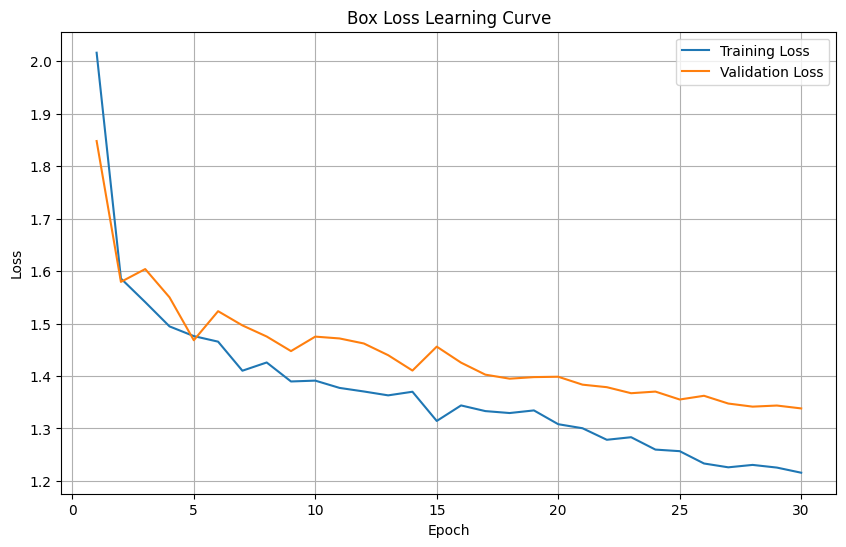

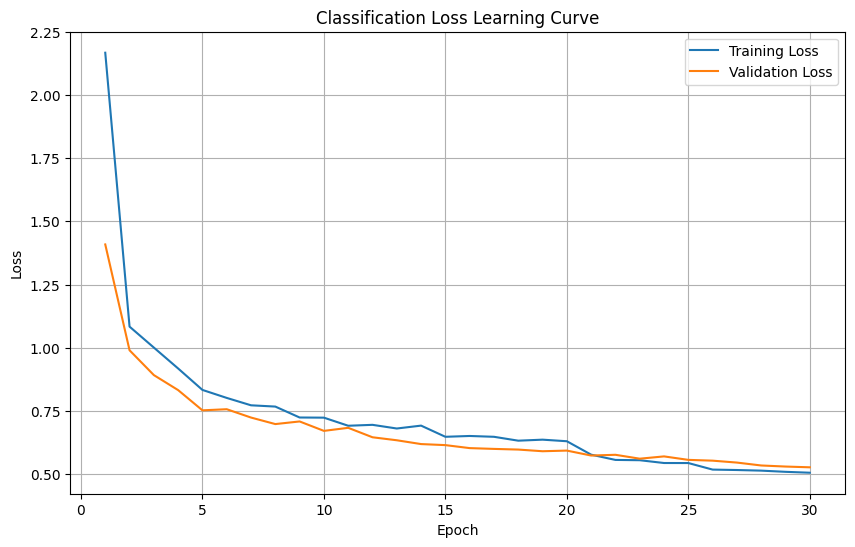

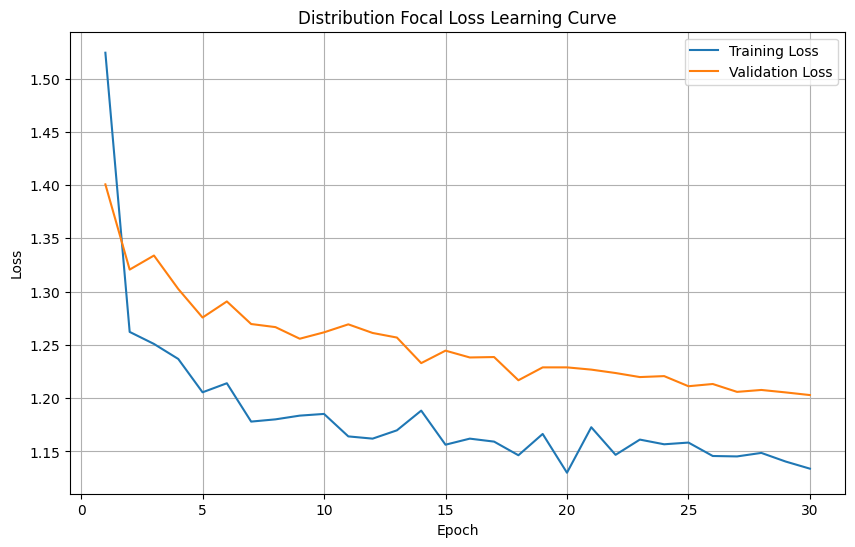

In [ ]:
def plot_learning_curve(df, train_column, val_column, title):

    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df[train_column], label='Training Loss')
    plt.plot(df['epoch'], df[val_column], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = os.path.join("/content/runs/detect/lane_detection_yolov8n", 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

In [ ]:
results_csv_path = os.path.join("/content/runs/detect/lane_detection_yolov8n", 'results.csv')
results_df = pd.read_csv(results_csv_path)

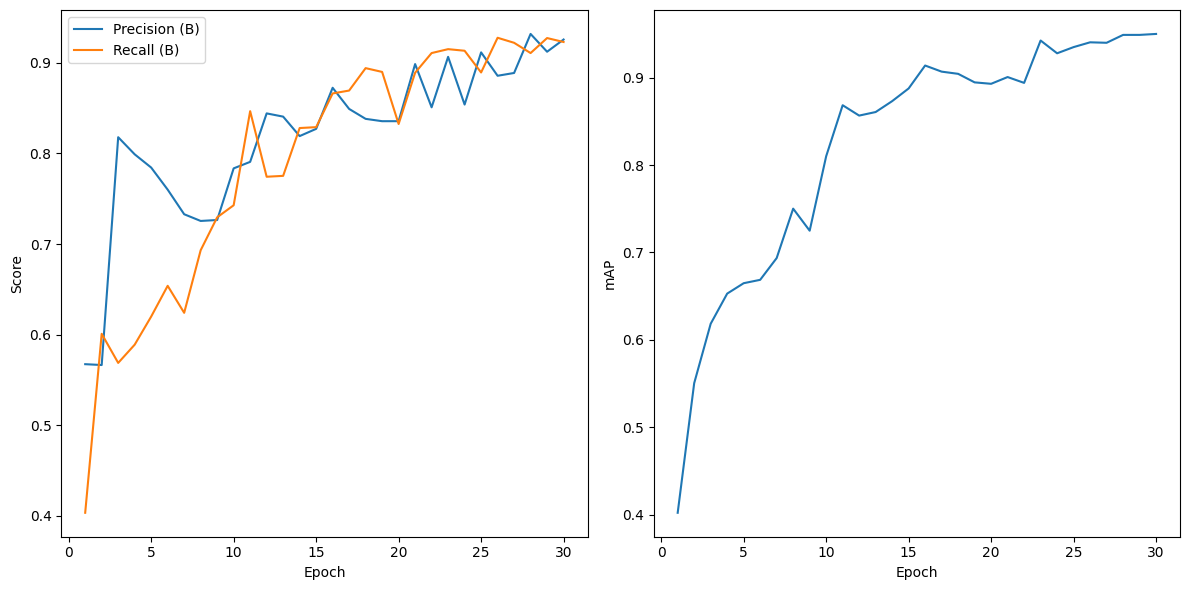

In [ ]:
epochs = results_df['epoch']
precision = results_df['metrics/precision(B)']
recall = results_df['metrics/recall(B)']
f1_score = results_df.get('f1_score', pd.Series([None]*len(epochs)))  # Default to empty if column not found
map_values = results_df['metrics/mAP50(B)']

plt.figure(figsize=(12, 6))

# Plot Precision and Recall
plt.subplot(1, 2, 1)
plt.plot(epochs, precision, label='Precision (B)')
plt.plot(epochs, recall, label='Recall (B)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Plot mAP
plt.subplot(1, 2, 2)
plt.plot(epochs, map_values, label='mAP50 (B)')
plt.xlabel('Epoch')
plt.ylabel('mAP')

plt.tight_layout()
plt.show()